Example 01

arg($\mathsf{a}$, 0.5). (**0.75**) \
arg($\mathsf{b}$, 0.5). (**0.75**) \
arg($\mathsf{c}$, 0.5). (**0.25**) \
arg($\mathsf{d}$, 0.5). (**0.5**) \
arg($\mathsf{e}$, 1). (**1**)

supp($\mathsf{b}$, $\mathsf{a}$). \
att($\mathsf{c}$, $\mathsf{a}$). \
supp($\mathsf{d}$, $\mathsf{a}$). \
supp($\mathsf{e}$, $\mathsf{b}$). \
att($\mathsf{e}$, $\mathsf{c}$).

In [1]:
%%capture
# install dependencies
import sys
!{sys.executable} -m pip install numpy sympy

In [2]:
import numpy as np
import sympy as sp
sp.init_printing()

a, b, c, d, e = sp.symbols('a b c d e')  # arguments

Define influence function for max-2 QE semantics via combine and impact:

In [3]:
energy, initial = sp.symbols('energy initial')
impact = lambda energy : sp.Max(0, energy)**2 / (1 + sp.Max(0, energy)**2)
combine = lambda initial, energy : initial - initial*impact(-energy) + (1-initial)*impact(energy)

We do not define an aggregation function, but instead, according to the topological order of the QBAG, manually define energies of arguments as $E_{\mathsf{x}} = \sum_{supp(\mathsf{y}, \mathsf{x})} \sigma_{\mathsf{y}} - \sum_{att(\mathsf{z}, \mathsf{x})} \sigma_{\mathsf{z}}$. 

In [4]:
E_a, E_b, E_c, E_d, E_e = sp.symbols('E_a E_b E_c E_d E_e')  # E_x - symbolic variable for the energy of argument x

First, $\mathsf{e}$ has no attackers or supporters, so its energy will be 0.

In [5]:
E_e = 0  # e has no children
fs_e = combine(e, E_e)  # fs_x - symbolic variable for the final strength of argument x
fs_e

In [6]:
e_initial = e.evalf(subs={e: 1.0}, chop=True)  # x_initial - initial strength of argument x
e_initial

In [7]:
e_final = fs_e.evalf(subs={e: e_initial})  # x_final - final strength of argument x
e_final

Similarly for $\mathsf{d}$:

In [8]:
E_d = 0  # d has no children
fs_d = combine(d, E_d)
fs_d

In [9]:
d_initial = d.evalf(subs={d: 0.5}, chop=True)
d_initial

In [10]:
d_final = fs_d.evalf(subs={d: d_initial, e: e_initial})
d_final

As $\mathsf{c}$ has only one child, namely attacker $\mathsf{e}$, we get:

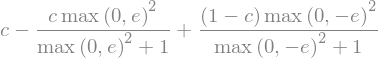

In [11]:
E_c = -fs_e  # e is the only attacker of c
fs_c = combine(c, E_c)
fs_c

In [12]:
c_initial = c.evalf(subs={c: 0.5}, chop=True)
c_initial

In [13]:
c_final = fs_c.evalf(subs={c: c_initial, e: e_initial})
c_final

Similarly for $\mathsf{b}$:

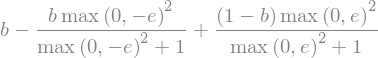

In [14]:
E_b = fs_e  # e is the only supporter of b
fs_b = combine(b, E_b)
fs_b

In [15]:
b_initial = b.evalf(subs={b: 0.5}, chop=True)
b_initial

In [16]:
b_final = fs_b.evalf(subs={b: b_initial, e: e_initial})
b_final

Finally, for $\mathsf{a}$, its final strength is eventually a function of the initial sstrengths of $\mathsf{a}$, $\mathsf{b}$, $\mathsf{c}$, $\mathsf{d}$, $\mathsf{e}$:

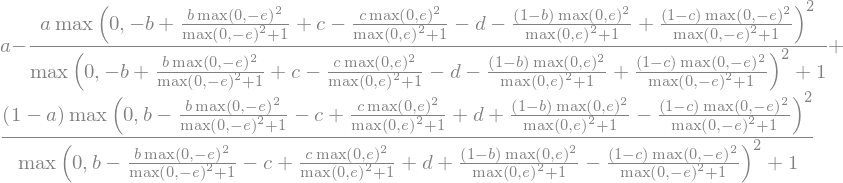

In [17]:
E_a = fs_b + fs_d - fs_c
fs_a = combine(a, E_a)
fs_a

In [18]:
a_initial = a.evalf(subs={a: 0.5}, chop=True)
a_initial

In [19]:
a_final = fs_a.evalf(subs={a: a_initial, b: b_initial, c: c_initial, d: d_initial, e: e_initial})
a_final

We can compute the contributions to $\mathsf{a}$ according to the gradient saliency method, evaluating them at the point of initial strengths.

In [20]:
pdfs_a_b = fs_a.diff(b)  # pdf_x - partial derivative of f wrt x
pdfs_a_c = fs_a.diff(c)
pdfs_a_d = fs_a.diff(d)
pdfs_a_e = fs_a.diff(e)

We can evaluate with `sympy` itself, e.g. $\left. \frac{\partial \sigma_{\mathsf{a}}}{\partial \mathsf{e}} \right|_{a_{initial}, b_{initial}, c_{initial}, d_{initial}, e_{initial}}$:

In [21]:
pdfs_a_e.evalf(subs = {a: a_initial, b: b_initial, c: c_initial, d: d_initial, e: e_initial})

But `numpy` is much more efficient at numerical evaluation

In [22]:
pdfs_a_b_eval = sp.lambdify([a, b, c, d, e], pdfs_a_b, 'numpy')
pdfs_a_b_eval(a_initial, b_initial, c_initial, d_initial, e_initial)

In [23]:
pdfs_a_c_eval = sp.lambdify([a, b, c, d, e], pdfs_a_c, 'numpy')
pdfs_a_c_eval(a_initial, b_initial, c_initial, d_initial, e_initial)

In [24]:
pdfs_a_d_eval = sp.lambdify([a, b, c, d, e], pdfs_a_d, 'numpy')
pdfs_a_d_eval(a_initial, b_initial, c_initial, d_initial, e_initial)

In [25]:
pdfs_a_e_eval = sp.lambdify([a, b, c, d, e], pdfs_a_e, 'numpy')
pdfs_a_e_eval(a_initial, b_initial, c_initial, d_initial, e_initial)